In [ ]:
# !pip install tensorflow-gpu

In [ ]:
# import tensorflow as tf
# print("TensorFlow version:", tf.__version__)
# print("Number of GPUs available:", len(tf.config.experimental.list_physical_devices('GPU')))


In [ ]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UITS_Research_Group/Federated Learning/Dataset/preprocessedData1.csv')

In [ ]:
df['Is Laundering'].value_counts()

0    2267576
1      55423
Name: Is Laundering, dtype: int64

In [ ]:
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,From Bank,To Bank,...,Payment Currency_Yen,Payment Currency_Yuan,Payment Format_ACH,Payment Format_Bitcoin,Payment Format_Cash,Payment Format_Cheque,Payment Format_Credit Card,Payment Format_Reinvestment,Payment Format_Wire,Is Laundering
0,0,0,0,1,0,1,0,0,4474,10438,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,47372,33210,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,12454,8497,...,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,2,0,0,0,21180,18106,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,79669,52217,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
# y = df["Is Laundering"].to_numpy()
# X = df.drop(columns=["Is Laundering"]).to_numpy()

In [ ]:
y = df["Is Laundering"]
X = df.drop(columns=["Is Laundering"])

In [ ]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (2322999, 52)
y shape: (2322999,)


### Deep Learning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Print the shapes of the resulting dataframes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2090699, 52)
y_train shape: (2090699,)
X_test shape: (232300, 52)
y_test shape: (232300,)


In [ ]:
import datetime, os

In [ ]:
%load_ext tensorboard
# %tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 50, 128)           512       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 25, 128)          0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 16)                9280      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9,809
Trainable params: 9,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)
loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(np.expand_dims(X_train, axis=2), y_train, epochs=1, batch_size=32, callbacks=[tensorboard_callback])

65335/65335 [==============================] - 1420s 22ms/step - loss: 0.0824 - accuracy: 0.9773


In [ ]:
 # model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# history = model.fit(np.expand_dims(X_train, axis=2), y_train, epochs=30, batch_size=32)

In [ ]:
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=2), y_test)


7260/7260 [==============================] - 69s 9ms/step - loss: 0.0804 - accuracy: 0.9769


In [ ]:
y_pred = model.predict(np.expand_dims(X_test, axis=2))
y_pred = np.round(y_pred)

7260/7260 [==============================] - 48s 6ms/step


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[226039    676]
 [  4680    905]]


In [ ]:
sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])

print(f"Sensitivity: {sensitivity}\nSpecificity: {specificity}")

Sensitivity: 0.9970182828661536
Specificity: 0.162041181736795


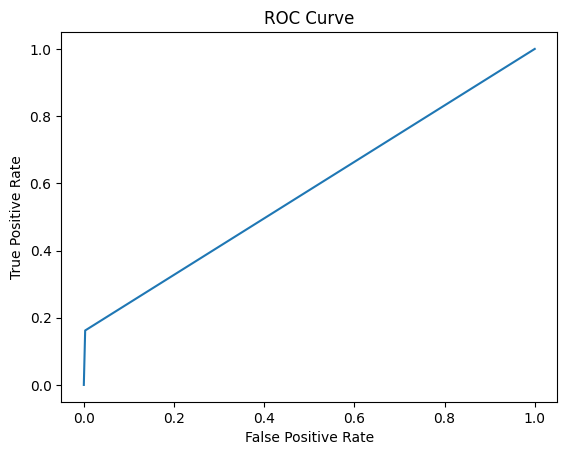

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
auc = roc_auc_score(y_test, y_pred)

print('AUC:', auc)

AUC: 0.5795297323014743


In [ ]:
%tensorboard --logdir logs

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state=42, k_neighbors=5)

In [ ]:
X, y = sm.fit_resample(X, y)

In [ ]:
y.value_counts()

0    2267576
1    2267576
Name: Is Laundering, dtype: int64

In [ ]:
new_df = pd.concat([X, y], axis=1)

In [ ]:
new_df = new_df.sample(frac=1, random_state=42)
new_df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,From Bank,To Bank,...,Payment Currency_Yen,Payment Currency_Yuan,Payment Format_ACH,Payment Format_Bitcoin,Payment Format_Cash,Payment Format_Cheque,Payment Format_Credit Card,Payment Format_Reinvestment,Payment Format_Wire,Is Laundering
1670928,0,0,0,1,0,1,0,0,4474,10438,...,0,0,1,0,0,0,0,0,0,0
430844,0,0,0,1,0,0,1,0,47372,33210,...,0,0,0,0,0,0,1,0,0,0
4209540,0,0,0,0,0,0,1,0,12454,8497,...,0,0,1,0,0,0,0,0,0,1
1131478,0,0,0,0,2,0,0,0,21180,18106,...,0,0,0,0,0,1,0,0,0,0
3509829,0,0,0,0,0,0,0,0,79669,52217,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
new_df.to_csv(f"/content/drive/MyDrive/Dataset/DatasetWithSmote.csv", index=False)

### XGboost

In [ ]:
import xgboost as xgb

In [ ]:
xgb_cl = xgb.XGBClassifier(booster="gbtree", max_depth=9,learning_rate=0.5802, early_stopping_rounds=10, min_child_weight=44, gamma=0.5646)

In [ ]:
evalset = [(X_train, y_train), (X_test,y_test)]
xgb_cl.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)

In [ ]:
y_pred = xgb_cl.predict(X_test)

In [ ]:
auc = roc_auc_score(y_test, y_pred)

print('AUC:', auc)

AUC: 0.7579224810595085


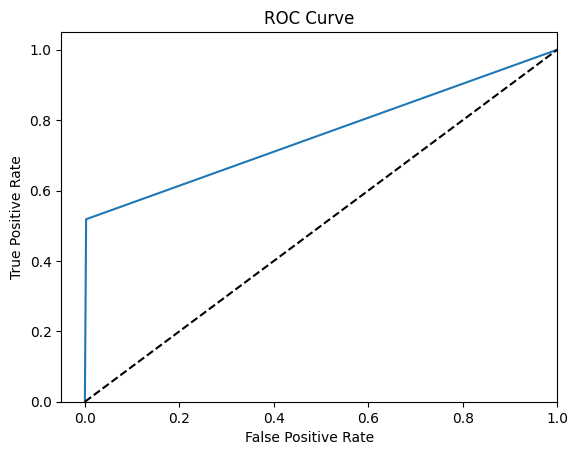

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[113089    291]
 [  1334   1436]]


In [ ]:
sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])

print(f"Sensitivity: {sensitivity}\nSpecificity: {specificity}")

Sensitivity: 0.9974334097724467
Specificity: 0.5184115523465704


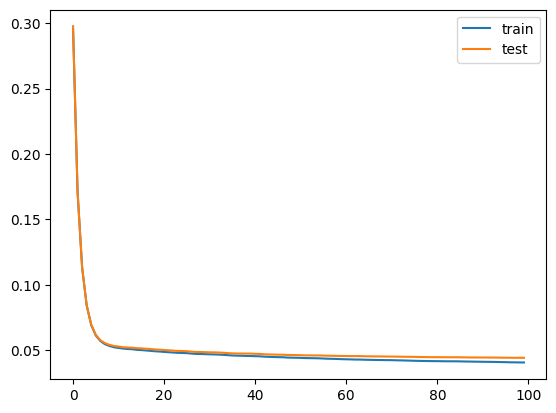

In [ ]:
results = xgb_cl.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state=42, k_neighbors=5)

In [ ]:
X, y = sm.fit_resample(X, y)

In [ ]:
y.value_counts()

0    2267576
1      55423
Name: Is Laundering, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

# Print the shapes of the resulting dataframes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2206849, 52)
y_train shape: (2206849,)
X_test shape: (116150, 52)
y_test shape: (116150,)


### Hyper-parameter tuning

In [ ]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 6.4 MB/s eta 0:00:00


In [ ]:
import ast
import sys
import json
from pathlib import Path
from dill.source import getsource
from dill import detect

import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp
from sklearn import metrics
from sklearn import model_selection
import xgboost as xgb

pd.set_option('display.max_columns', None)

In [ ]:
from wandb.xgboost import WandbCallback
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
WANDB_PROJECT ='FL_OB_2_without_smote'

In [ ]:
sweep_config = {
  "name" : "btc_hyperparam_search",
  "method" : "random",
  "parameters" : {
    "booster": {
        "values": ["gbtree", "gblinear"]
    },
    "learning_rate": {
      "min": 0.001,
      "max": 1.0
    },
    "gamma": {
      "min": 0.001,
      "max": 1.0
    },
    "max_depth": {
        "values": [3, 5, 7, 9, 12]
    },
    "min_child_weight": {
      "min": 1,
      "max": 150
    },
    "early_stopping_rounds": {
      "values" : [10, 20, 40, 60, 80]
    },
  }
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: dfg09i6o
Sweep URL: https://wandb.ai/overflow/FL_OB_2_without_smote/sweeps/dfg09i6o


In [ ]:
def train():
  config_defaults = {
    "booster": "gbtree",
    "max_depth": 3,
    "learning_rate": 0.1,
    "subsample": 1,
    "seed": 117,
    "test_size": 0.33,
  }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  # fit model on train


  model = XGBClassifier(booster=config.booster, max_depth=config.max_depth,
                        learning_rate=config.learning_rate, subsample=config.subsample)


  model.fit(X_train, y_train)

  # make predictions on test
  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]

  # evaluate predictions
  accuracy = accuracy_score(y_test, predictions)
  print(f"Accuracy: {accuracy:.0%}")
  wandb.log({"accuracy": accuracy})

In [ ]:
wandb.agent(sweep_id, train, count=25)

wandb: Agent Starting Run: yaq802jt with config:
wandb: 	booster: gbtree
wandb: 	early_stopping_rounds: 80
wandb: 	gamma: 0.6310857972524563
wandb: 	learning_rate: 0.5457931871927006
wandb: 	max_depth: 12
wandb: 	min_child_weight: 4
wandb: Currently logged in as: shubhoc47 (overflow). Use `wandb login --relogin` to force relogin


wandb: Ctrl + C detected. Stopping sweep.
